In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as sl

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn import linear_model

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor


%matplotlib inline
import scipy as sc
import math as ma
from scipy import linalg, optimize, constants, interpolate, special, stats
from math import exp, pow, sqrt, log

import seaborn as sns #spezielle Graphikdarstellungen
import statsmodels.api as sm
import statsmodels.stats.api as sms

#import theano 
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import InputLayer,Dense, Activation
from keras.optimizers import SGD #Stochastic Gradient Descent
from keras.utils import to_categorical  
from keras.utils import plot_model

from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score,root_mean_squared_error


In [3]:
# Read data 

header_pr = ['Year','Month','Day','Hour','pr']
t = ['Year','Month','Day','Hour']
pr_data = pd.read_csv("dataset/pr_hourly_DWD_ID1550.dat",delim_whitespace=True,header=None,names=header_pr,skipinitialspace=True)
q_data = pd.read_csv("dataset/Q_hourly_ID16425004.dat")
print(pr_data.head())
print(q_data.head())


C:\Users\davee\AppData\Local\Temp\ipykernel_19036\3014387338.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pr_data = pd.read_csv("dataset/pr_hourly_DWD_ID1550.dat",delim_whitespace=True,header=None,names=header_pr,skipinitialspace=True)


   Year  Month  Day  Hour   pr
0  1995      9    1     0  0.0
1  1995      9    1     1  0.0
2  1995      9    1     2  0.0
3  1995      9    1     3  0.0
4  1995      9    1     4  0.0
   Year  Month  Day  Hour     Q
0  1920     11    1     0  2.46
1  1920     11    1     1  2.46
2  1920     11    1     2  2.46
3  1920     11    1     3  2.46
4  1920     11    1     4  2.46


In [4]:
#Merge Data (Pr and Q)

data = pd.merge(pr_data, q_data, on=['Year', 'Month', 'Day', 'Hour'])

print(data.head())
print(data.tail())

   Year  Month  Day  Hour   pr       Q
0  1995      9    1     0  0.0  11.888
1  1995      9    1     1  0.0  11.745
2  1995      9    1     2  0.0  11.601
3  1995      9    1     3  0.0  11.457
4  1995      9    1     4  0.0  11.313
        Year  Month  Day  Hour   pr      Q
213307  2019     12   31    19  0.0  1.965
213308  2019     12   31    20  0.0  1.965
213309  2019     12   31    21  0.0  1.965
213310  2019     12   31    22  0.0  1.965
213311  2019     12   31    23  0.0  1.965


In [5]:
# Remove date columns from data for easier read
# create date_time for the storage of date

date_time = pd.to_datetime(data[['Year', 'Month', 'Day', 'Hour']])
data = data.drop(columns=['Year', 'Month', 'Day', "Hour"])

date_time.head()

0   1995-09-01 00:00:00
1   1995-09-01 01:00:00
2   1995-09-01 02:00:00
3   1995-09-01 03:00:00
4   1995-09-01 04:00:00
dtype: datetime64[ns]

In [6]:
print(data.info())
print(data.describe())

# No missing values
# Error values at -99999

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213312 entries, 0 to 213311
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   pr      213312 non-null  float64
 1   Q       213312 non-null  float64
dtypes: float64(2)
memory usage: 3.3 MB
None
                  pr              Q
count  213312.000000  213312.000000
mean     -398.788224       4.029294
std      6303.568137       3.136641
min    -99999.000000       0.162000
25%         0.000000       1.788000
50%         0.000000       3.167000
75%         0.000000       5.377000
max        37.100000      64.457000


In [7]:
#Replace -99999 with NaN then handle missing values with Interpolation
data.loc[data['pr'] < 0, 'pr'] = np.nan

#time series Interpolation
data['timestamp'] = date_time
data.set_index('timestamp', inplace=True)
data['pr'] = data['pr'].interpolate(method='time')

In [11]:
#Create lag features for Q
for lag in range(1,7):
    data[f'Q_t-{lag}'] = data['Q'].shift(lag)
    
#Target Variable
data['Q_t+6'] = data['Q'].shift(-6)

#Drop rows with NaN values caused by lagging
data.dropna(inplace=True)

print(data)

                      pr       Q   Q_t-1   Q_t-2   Q_t-3   Q_t-4   Q_t-5  \
timestamp                                                                  
1995-09-01 06:00:00  0.1  11.026  11.170  11.313  11.457  11.601  11.745   
1995-09-01 07:00:00  0.2  10.882  11.026  11.170  11.313  11.457  11.601   
1995-09-01 08:00:00  0.2   8.551  10.882  11.026  11.170  11.313  11.457   
1995-09-01 09:00:00  0.3  10.758   8.551  10.882  11.026  11.170  11.313   
1995-09-01 10:00:00  0.8  10.109  10.758   8.551  10.882  11.026  11.170   
...                  ...     ...     ...     ...     ...     ...     ...   
2019-12-31 13:00:00  0.0   1.964   1.964   1.964   1.964   1.964   1.964   
2019-12-31 14:00:00  0.0   1.964   1.964   1.964   1.964   1.964   1.964   
2019-12-31 15:00:00  0.0   1.965   1.964   1.964   1.964   1.964   1.964   
2019-12-31 16:00:00  0.0   1.965   1.965   1.964   1.964   1.964   1.964   
2019-12-31 17:00:00  0.0   1.965   1.965   1.965   1.964   1.964   1.964   

           

In [12]:
# updatable plot

from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [13]:
X = data[['pr','Q','Q_t-1','Q_t-2','Q_t-3','Q_t-4','Q_t-5','Q_t-6']].values
y = data['Q_t+6'].values


scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape input for LSTM (samples, timesteps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)



In [1]:
for i in range(1,10,2):
    print(i)

1
3
5
7
9


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 550us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 517us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 551us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 576us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 571us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 573us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 511us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 594us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 581us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 583us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 566us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 526us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 554us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 523us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 527us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 532us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 547us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 548us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 565us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 525us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 546us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 540us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 550us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 530us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 546us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 570us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 540us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 556us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 544us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 514us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 540us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 549us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 4s 769us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 547us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 583us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 528us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 4s 807us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 580us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 537us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 569us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 575us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 543us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 582us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 548us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 553us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 537us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 642us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 555us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 584us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 539us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 561us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 522us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 544us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 588us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 563us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 551us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 563us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 602us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 559us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 581us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 579us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 530us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 597us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 578us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 566us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 515us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 532us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 514us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 530us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 543us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 526us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 530us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 527us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 519us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 543us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 513us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 4s 843us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 581us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 568us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 561us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 591us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 578us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 612us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 612us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 629us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 573us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 568us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 526us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 557us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 554us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 542us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 526us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 561us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 556us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 544us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 546us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 546us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 530us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 560us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 525us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 568us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 550us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 538us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 543us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 562us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 537us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 549us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 530us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 582us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 575us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 526us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 564us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 533us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 561us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 548us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 566us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 576us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 630us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 605us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 592us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 559us/step


c:\Users\davee\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4666/4666 ━━━━━━━━━━━━━━━━━━━━ 3s 687us/step
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 598us/step


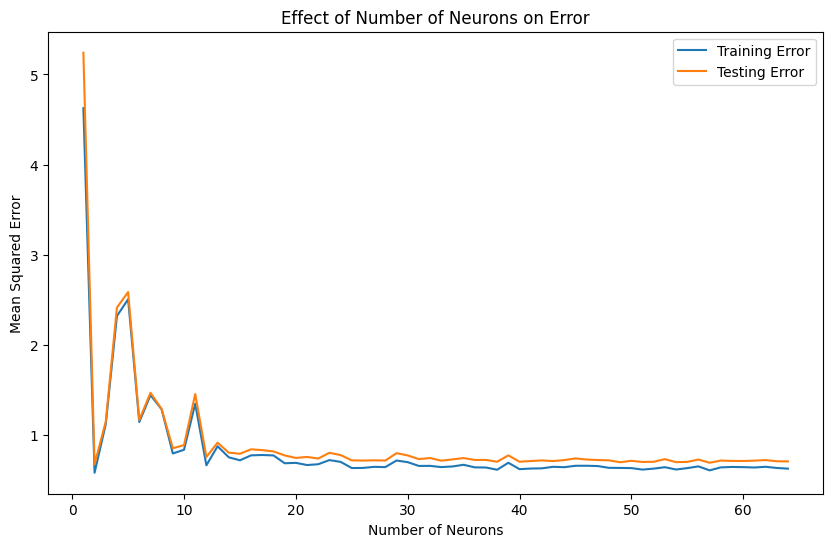

In [22]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM
from keras.models import Sequential

EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,restore_best_weights=True)

neuron_range = range(1, 65, 1)  
train_errors = []
test_errors = []

#Optimizer
adam = Adam(learning_rate=0.001)

for n in neuron_range:
    
    # Build the model
    model = Sequential()
    model.add(LSTM(n, activation='relu', input_shape=(6, X.shape[2])))  # 6 timesteps, 7 features
    model.add(Dense(1))  # Single output for regression
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train,
          shuffle=False,
          epochs=5, 
          batch_size=64,
          verbose=0,
          validation_data=(X_test, y_test),                  
          callbacks=[EarlyStopping])
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))

# Plot the errors against number of estimators
plt.figure(figsize=(10, 6))
plt.plot(neuron_range, train_errors, label='Training Error')
plt.plot(neuron_range, test_errors, label='Testing Error')
plt.xlabel('Number of Neurons')
plt.ylabel('Mean Squared Error')
plt.title('Effect of Number of Neurons on Error')
plt.legend()
plt.show()

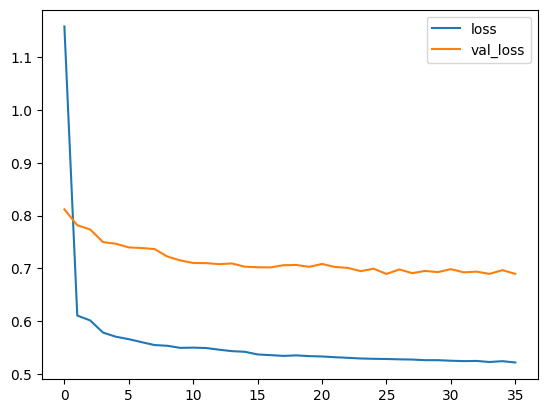

9332/9332 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.4359 - mae: 0.2385 - val_loss: 0.6895 - val_mae: 0.3381


In [24]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM
from keras.models import Sequential

EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True)
# Build the model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(6, X.shape[2])))  # 6 timesteps, 7 features
model.add(Dense(1))  # Single output for regression

# Compile the model
model.compile(optimizer='adam', loss='mse')

#Optimizer
adam = Adam(learning_rate=0.001)
#sgd = SGD(learning_rate=0.005)

model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mae'])

model.fit(X_train, y_train,
          shuffle=False,
          epochs=50, #300,
          batch_size=16,
          verbose=1,
          validation_data=(X_test, y_test),                  
          callbacks=[plot_losses, EarlyStopping])


In [25]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

# Print evaluation results
print(f"Test Loss (MSE): {test_loss}")
print(f"Mean Absolute Error (MAE): {test_mae}")

#predict on test set
y_pred = model.predict(X_test)

# Calculate RMSE and R² score
rmse = np.sqrt(test_loss)  # Since test_loss = MSE
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Test Loss (MSE): 0.6893364191055298
Mean Absolute Error (MAE): 0.34612253308296204
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 653us/step
Root Mean Squared Error (RMSE): 0.830262861451438
R² Score: 0.9311056069218905


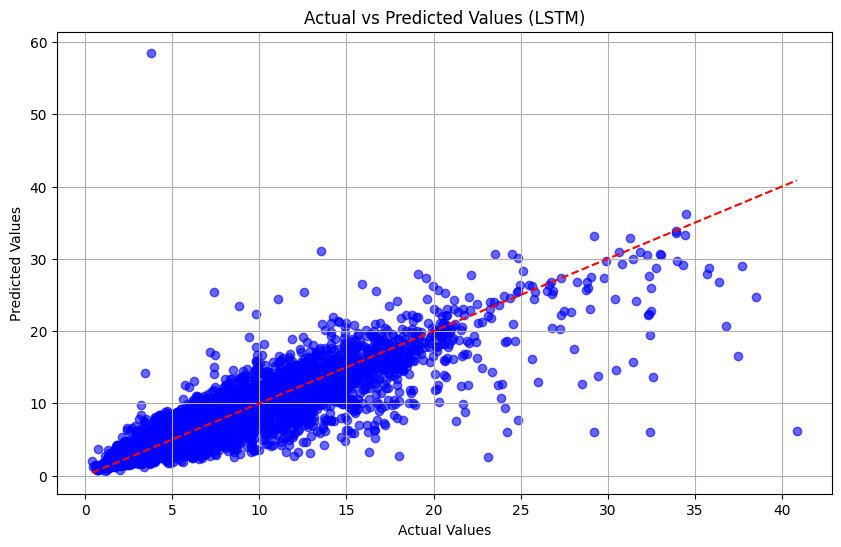

In [28]:


# Plot Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.title('Actual vs Predicted Values (LSTM)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()


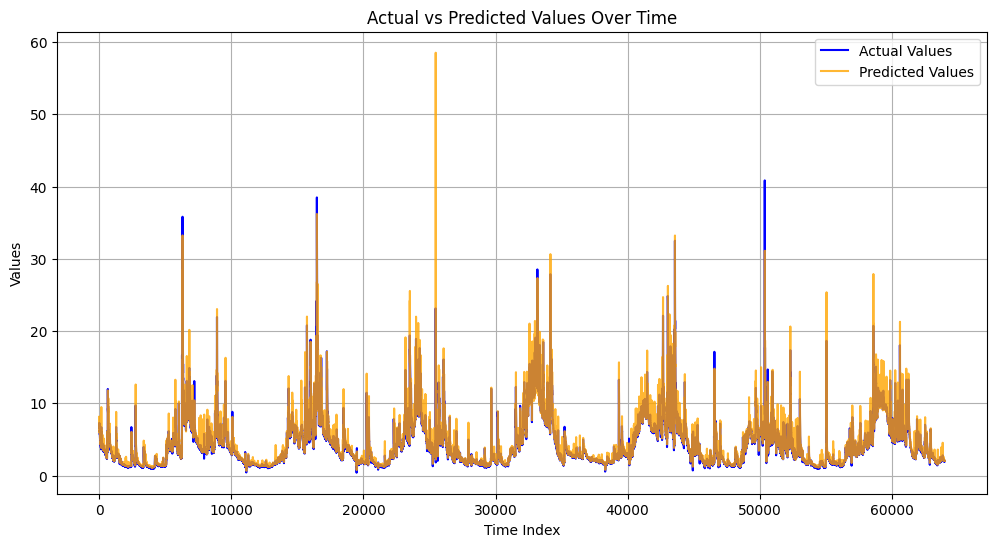

In [27]:
# Plot Predicted vs Actual values over a time index
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', color='blue')
plt.plot(range(len(y_pred)), y_pred, label='Predicted Values', color='orange', alpha=0.8)
plt.title('Actual vs Predicted Values Over Time')
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()
